<a href="https://colab.research.google.com/github/ddecosmo-dev/thread-checker/blob/main/threadCheckerTrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
#import libraries and download testing data from kaggle
#!kaggle datasets download -d devindecosmo/bolt-only-thread-checker-rev-1
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# You will be prompted to upload your 'kaggle.json' API key file.
# This only needs to be done once per session.
if not os.path.exists("/root/.kaggle/kaggle.json"):
    from google.colab import files
    print("Please upload your kaggle.json file")
    files.upload()
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

# The name of the main folder that gets created after unzipping
# Change 'training' if your main folder is named something else
dataset_folder = 'Thread Checker Rev 1, bolts only'

if not os.path.exists(dataset_folder):
  print('Dataset not found. Downloading...')
  # Replace with the API command you copied from your dataset's Kaggle page
  !kaggle datasets download -d devindecosmo/thread-checker-bolts-only-3

  # Replace with the actual name of the downloaded .zip file
  !unzip -q thread-checker-bolts-only-3.zip
  print('Download and unzip complete.')
else:
  print('Dataset already exists.')

Dataset already exists.


In [84]:

#Constants
#data set creation
VALIDATION_SPLIT = 0.2
SEED = 123;

#Data preparation
BATCH_SIZE = 16
#standard is 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

#Model

#Training
EPOCHS = 40



# Define the correct paths to your nested data directories
# Note: This assumes your unzipped folder is named 'Thread Checker Rev 1, bolts only'
TRAIN_DIR = 'Thread Checker Rev 1, bolts only/training'

In [85]:
#dataset import and creation
#may need some scaling or bounding box depending on accuracy
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  validation_split=VALIDATION_SPLIT,
  subset="training",
  seed=123,  # The seed ensures the random split is the same every time
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode='categorical') # Add this line to get one-hot encoded labels

# We create the validation set from the remaining 20%
val_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  validation_split=VALIDATION_SPLIT,
  subset="validation",
  seed=123, # Using the same seed is crucial to prevent overlap
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode='categorical') # Add this line to get one-hot encoded labels


# Get the class names from the folder structure
class_names = train_ds.class_names
num_classes = len(class_names)
print("Found the following classes:", class_names)

"""
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    # Use the label directly as the index
    label_index = labels[i]

    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[label_index])
    plt.axis("off")
plt.show()
"""

Found 108 files belonging to 3 classes.
Using 87 files for training.
Found 108 files belonging to 3 classes.
Using 21 files for validation.
Found the following classes: ['bolt_0.125in', 'bolt_0.25in', 'bolt_0.375in']


'\nplt.figure(figsize=(10, 10))\nfor images, labels in train_ds.take(1):\n  for i in range(9):\n    ax = plt.subplot(3, 3, i + 1)\n\n    # Use the label directly as the index\n    label_index = labels[i]\n\n    plt.imshow(images[i].numpy().astype("uint8"))\n    plt.title(class_names[label_index])\n    plt.axis("off")\nplt.show()\n'

In [86]:
# --- 3. CONFIGURE DATASETS FOR PERFORMANCE ---
# These steps optimize the data pipeline for speed during training.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\nDatasets are loaded, prepared, and ready for training.")


Datasets are loaded, prepared, and ready for training.


In [87]:
#data preparation

#resizing

#normalizing

#batching

In [88]:
#feature engineering

In [89]:
#model selection and training
# --- 4. PREPARE THE MODEL (Transfer Learning) ---

# Create a data augmentation layer to prevent overfitting and improve generalization.
#randomly changes the postion and orientation to improve training
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
], name="data_augmentation")

# Get the specific preprocessing function required for MobileV2
#is this normalization
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Load the pre-trained base model from Keras.
# We freeze its weights so we only train our new final layers.
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                               include_top=False, # Don't include the final ImageNet classifier
                                               weights='imagenet')
base_model.trainable = False # Freeze the convolutional base

# Create our own classification head to place on top of the base model
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)      # 1. Apply augmentation
x = preprocess_input(x)            # 2. Preprocess for MobileNetV2
x = base_model(x, training=False)  # 3. Run the base model
x = tf.keras.layers.GlobalAveragePooling2D()(x) # 4. Pool features to a single vector, final layer before final
x = tf.keras.layers.Dropout(0.2)(x) # 5. Add dropout to prevent overfitting, randomly turns off nuerons to improve operability
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x) # 6. Final prediction layer

# Chain all the pieces together into the final model
model = tf.keras.Model(inputs, outputs)

# Print a summary of the model's architecture
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_5 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_5 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [90]:
# Compile the model, configuring it for training
#come back and do more research on alternatives, or ways
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully.")

Model compiled successfully.


In [91]:
#train model
# Set the number of epochs to train for
# Start the training process

print("Starting model training...")
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS
)

print("Model training complete.")

Starting model training...
Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 849ms/step - accuracy: 0.2571 - loss: 1.3229 - val_accuracy: 0.2381 - val_loss: 1.3594
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 406ms/step - accuracy: 0.3538 - loss: 1.3225 - val_accuracy: 0.2381 - val_loss: 1.2882
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 398ms/step - accuracy: 0.3220 - loss: 1.1982 - val_accuracy: 0.4286 - val_loss: 1.0802
Epoch 4/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 394ms/step - accuracy: 0.4611 - loss: 1.0349 - val_accuracy: 0.5238 - val_loss: 0.9565
Epoch 5/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - accuracy: 0.5332 - loss: 0.9288 - val_accuracy: 0.3810 - val_loss: 1.0226
Epoch 6/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.5755 - loss: 0.9774 - val_accuracy: 0.6190 - val_loss: 0.8838
Epoch 7/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 451ms/step - accuracy: 0.6160 - loss: 0.9005 - val_accuracy: 0.7143 - val_loss: 0.8259
Epoch 8/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - accuracy: 0.6337 - loss: 0.8352 - val_

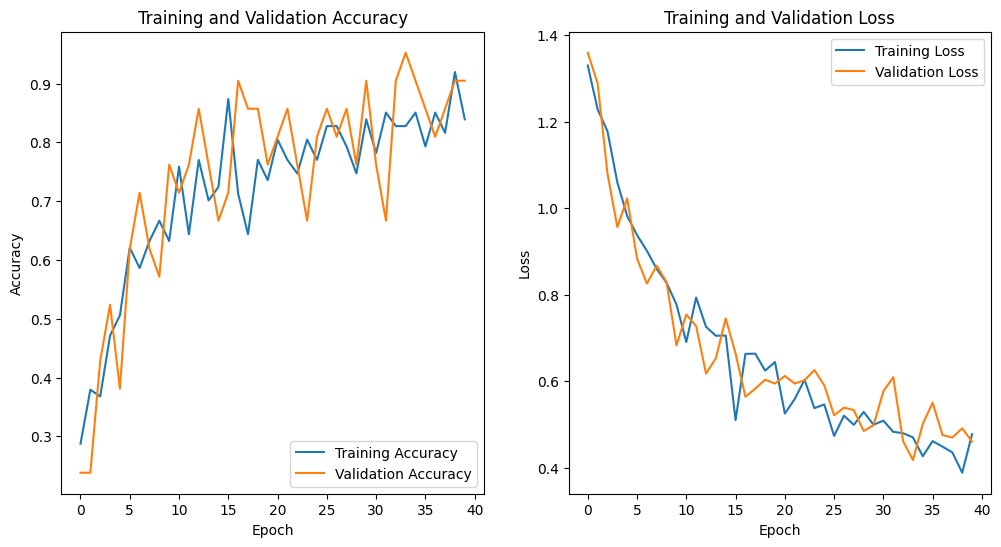

In [92]:
#training metrics
# Extract the accuracy history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract the loss history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs_range = range(EPOCHS)

# Plot Training and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()